# Project Overview
Using machine learning techniques, we aim to fine tune and build a model that can identify companies as investment grade or non-investment grade based on available financial metrics. Rating agencies routinely assign credit ratings to public companies, and these ratings influence funding and investment decisions for many financial firms.

# Data and preprocessing

In [1]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import mode
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
# import data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/corporateCreditRatingWithFinancialRatios.csv')

# preview the dataset
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [3]:
# inspect the data type of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rating Agency                  7805 non-null   object 
 1   Corporation                    7805 non-null   object 
 2   Rating                         7805 non-null   object 
 3   Rating Date                    7805 non-null   object 
 4   CIK                            7805 non-null   int64  
 5   Binary Rating                  7805 non-null   int64  
 6   SIC Code                       7805 non-null   float64
 7   Sector                         7805 non-null   object 
 8   Ticker                         7805 non-null   object 
 9   Current Ratio                  7805 non-null   float64
 10  Long-term Debt / Capital       7805 non-null   float64
 11  Debt/Equity Ratio              7805 non-null   float64
 12  Gross Margin                   7805 non-null   f

From this output, we can see that most features are numerical. However, we have some qualitative or categorical predictors that need to be transformed. We will process the categorical variables using LabelEncoder() in the next few cells.

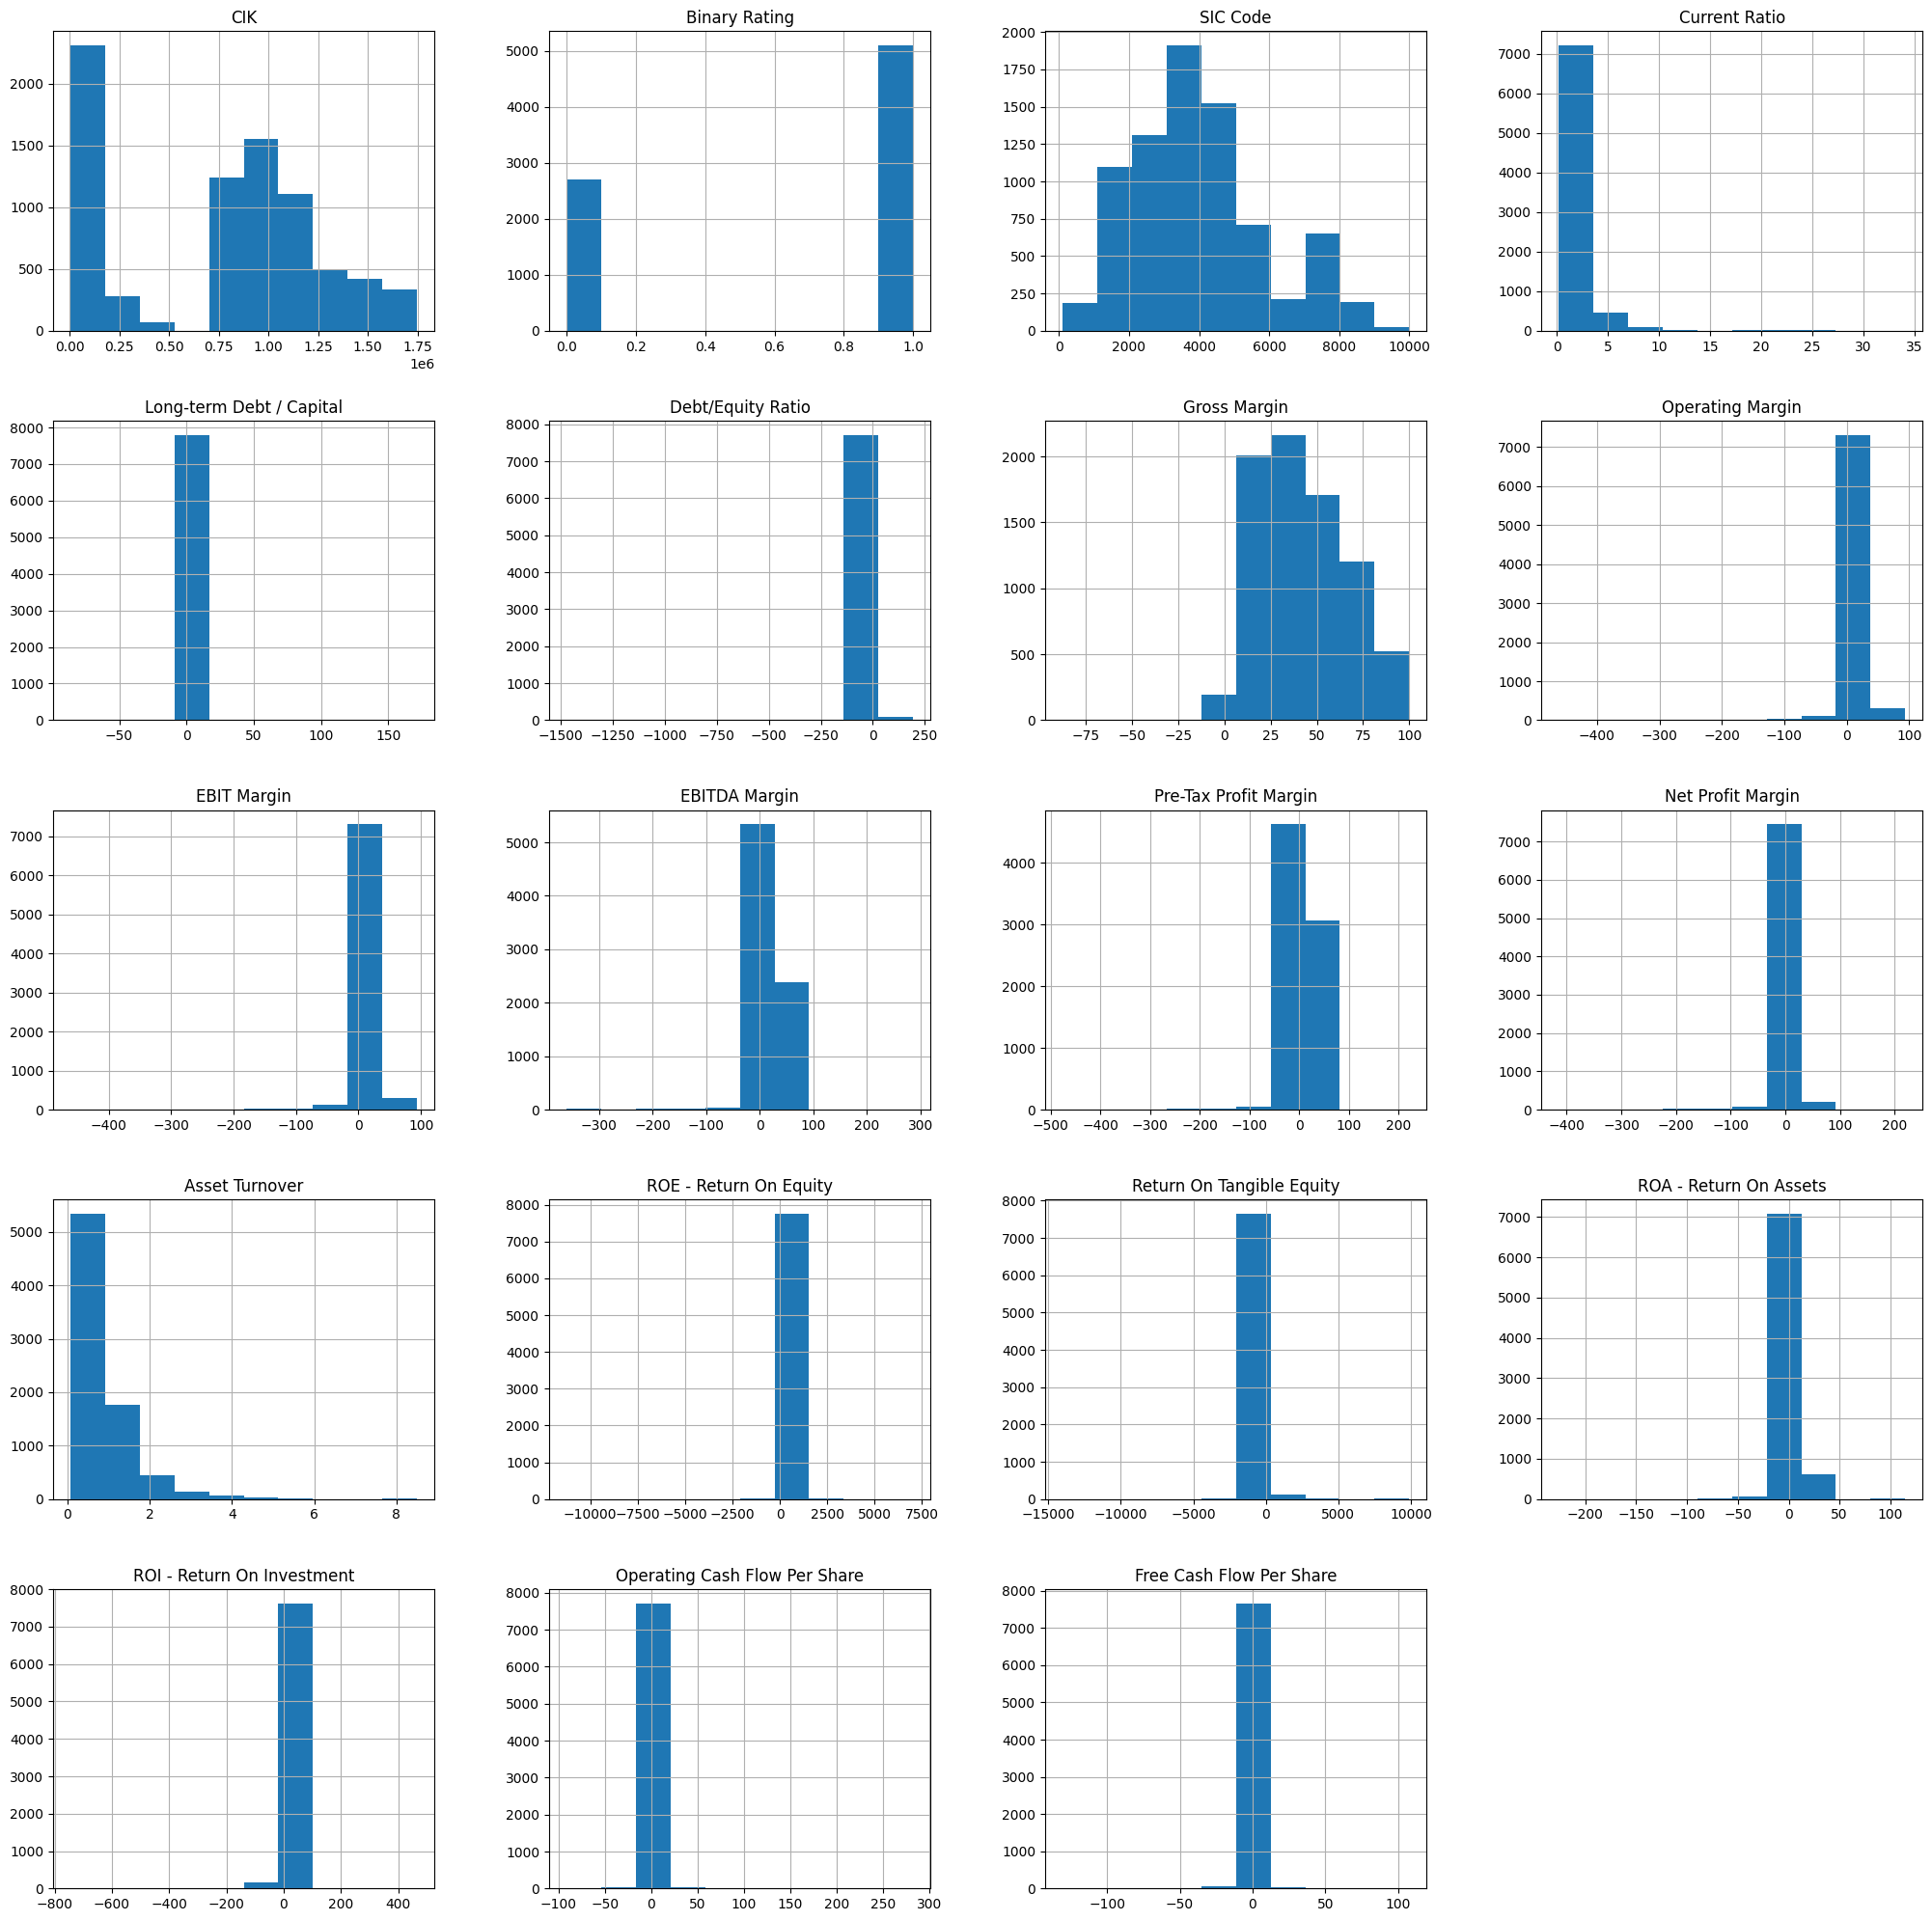

In [4]:
# inspect the distribution for each attribute in the dataset
ax = data.hist(figsize=(25,25))

In [5]:
corr_matrix = data.iloc[:, 9:].corr()
corr_matrix

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
Current Ratio,1.000000,-0.004422,0.007607,-0.119005,-0.039968,-0.040325,-0.095895,-0.036191,-0.018826,-0.049083,-0.022254,-0.008224,-0.002297,-0.025053,-0.021045,0.006524
Long-term Debt / Capital,-0.004422,1.000000,-0.004481,-0.000660,-0.010255,-0.010299,-0.007124,-0.015440,-0.017155,-0.010404,0.001803,-0.004122,-0.018936,0.551874,0.011356,0.012966
Debt/Equity Ratio,0.007607,-0.004481,1.000000,0.003872,0.001333,0.001393,-0.001535,0.007330,0.005694,-0.003112,0.462107,0.003809,0.008044,0.007103,0.007197,-0.003935
Gross Margin,-0.119005,-0.000660,0.003872,1.000000,0.180366,0.180612,0.364032,0.138797,0.109143,-0.505110,-0.000769,-0.028778,0.045433,0.018835,0.010243,-0.011238
Operating Margin,-0.039968,-0.010255,0.001333,0.180366,1.000000,0.999700,0.920759,0.916338,0.879209,-0.107301,-0.001834,0.012389,0.754847,0.423420,0.199485,-0.079138
EBIT Margin,-0.040325,-0.010299,0.001393,0.180612,0.999700,1.000000,0.921193,0.916165,0.879104,-0.108046,-0.001836,0.012313,0.754676,0.423368,0.202016,-0.079564
EBITDA Margin,-0.095895,-0.007124,-0.001535,0.364032,0.920759,0.921193,1.000000,0.819170,0.767419,-0.274075,-0.010407,0.005155,0.638675,0.362099,0.189693,-0.084401
Pre-Tax Profit Margin,-0.036191,-0.015440,0.007330,0.138797,0.916338,0.916165,0.819170,1.000000,0.965150,-0.049702,0.004329,0.026279,0.797267,0.447459,0.188690,-0.070633
Net Profit Margin,-0.018826,-0.017155,0.005694,0.109143,0.879209,0.879104,0.767419,0.965150,1.000000,-0.039706,0.011475,0.027545,0.787621,0.447371,0.180768,-0.076348
Asset Turnover,-0.049083,-0.010404,-0.003112,-0.505110,-0.107301,-0.108046,-0.274075,-0.049702,-0.039706,1.000000,0.024105,0.065913,0.113655,0.091659,0.017271,0.022692


Some cells in the correlation matrix have high values exceeding 0.9. For instance, EBIT Margin and Operating Margin have a correlation of 0.999700, and this makes sense because the value of EBIT is used to calculate operating margin. Evidently, our dataset has some multicollinearity. We will address this later using the variance inflation factor (VIF).

In [6]:
# instantiate an inputer to fill empty values, if they exist, with the average
imputer = SimpleImputer(strategy='mean')

# we apply the inputer to the numerical columns on the copy of a dataset
data_imputed = data.copy()
numeric_columns = data_imputed.select_dtypes(include=['float64', 'int64']).columns
data_imputed[numeric_columns] = imputer.fit_transform(data_imputed[numeric_columns])

# encode categorical variables
categorical_columns = data_imputed.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col, le in label_encoders.items():
    data_imputed[col] = le.fit_transform(data_imputed[col])

# identify X and y columns
X = data_imputed.drop(columns=['Binary Rating', 'Rating'])
y = data_imputed['Binary Rating'] # use 'Binary Rating' as target

# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# display the first few rows of the preprocessed dataset
pd.DataFrame(X_scaled, columns=X.columns).head()

,Rating Agency,Corporation,Rating Date,CIK,SIC Code,Sector,Ticker,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,1.012624,-1.501919,-2.266516,0.621676,0.474907,1.478474,-1.430202,-0.403644,0.000873,0.020530,...,0.365559,0.177621,0.096734,-0.764973,-0.033733,-0.028709,-0.209897,-0.107590,0.250559,-0.034852
1,1.012624,-1.401681,-2.251855,-1.416414,1.775470,-1.673453,-1.681879,-0.423316,-0.169496,-0.004936,...,0.158597,0.438188,0.314851,-0.743282,0.026390,0.055768,-0.008809,0.607060,-0.037958,0.026707
2,1.012624,-1.386645,-2.219599,-1.416048,0.541192,0.905397,-1.450747,0.000670,-0.061013,0.007202,...,-0.674261,-0.201199,-0.160213,2.315788,-0.010031,-0.010120,0.075563,0.105548,-1.336750,-1.026112
3,1.012624,-1.045836,-2.275313,0.579481,0.474907,1.478474,-0.849804,-0.567524,0.006845,0.022399,...,0.322665,0.231604,0.125926,-0.797580,-0.027363,-0.025459,-0.207752,-0.080978,0.208925,-0.140544
4,1.012624,-1.010752,-2.272381,-0.030702,0.571661,0.905397,-1.209342,-0.329536,-0.071664,0.006567,...,-0.758313,-0.266630,-0.222157,5.857507,-0.020925,-0.004459,-0.177620,0.045459,0.246725,0.316813


Now that we've scaled the predictors, we will address highly correlated variables using VIF.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# display sorted VIF values to identify multicollinearity
vif_data.sort_values(by="VIF", ascending=False)

,Feature,VIF
12,EBIT Margin,1706.838440
11,Operating Margin,1700.998744
14,Pre-Tax Profit Margin,21.518199
15,Net Profit Margin,15.488553
13,EBITDA Margin,10.611327
6,Ticker,6.200938
1,Corporation,6.199207
19,ROA - Return On Assets,4.689609
20,ROI - Return On Investment,3.221048
8,Long-term Debt / Capital,2.023931


In [8]:
# identify the features with high VIF and remove them from the set of predictors
collinear_features = ["Operating Margin", "EBITDA Margin", "Net Profit Margin", "Pre-Tax Profit Margin", "Ticker"]
X_reduced = X.drop(columns=collinear_features)

X_reduced_scaled = scaler.fit_transform(X_reduced)
vif_reduced = pd.DataFrame()
vif_reduced["Feature"] = X_reduced.columns
vif_reduced["VIF"] = [variance_inflation_factor(X_reduced_scaled, i) for i in range(X_reduced_scaled.shape[1])]

# display reduced VIF values in order
vif_reduced.sort_values(by="VIF", ascending=False)

,Feature,VIF
14,ROA - Return On Assets,4.122749
15,ROI - Return On Investment,3.203258
10,EBIT Margin,2.790320
7,Long-term Debt / Capital,2.018336
11,Asset Turnover,1.513103
9,Gross Margin,1.421275
12,ROE - Return On Equity,1.280923
8,Debt/Equity Ratio,1.274426
4,SIC Code,1.118949
6,Current Ratio,1.079114


In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced_scaled, y, test_size=0.2, random_state=42)

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [11]:
y_train_balanced.value_counts()

,count
Binary Rating,
1.0,4060
0.0,4060


# kNN classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# initialize knn
knn = KNeighborsClassifier(n_neighbors=5)

# train the model and make predictions
knn.fit(X_train_balanced, y_train_balanced)
knn_predictions = knn.predict(X_test)

# generate a report
knn_report = classification_report(y_test, knn_predictions, target_names = ['IG', 'Non-IG'])

# display the report's results
print(knn_report)

              precision    recall  f1-score   support

          IG       0.80      0.91      0.85       522
      Non-IG       0.95      0.88      0.92      1039

    accuracy                           0.89      1561
   macro avg       0.87      0.90      0.88      1561
weighted avg       0.90      0.89      0.89      1561



## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

# initialize logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# train the model and make predictions
log_reg.fit(X_train_balanced, y_train_balanced)
log_reg_predictions = log_reg.predict(X_test)

# generate a report
log_reg_report = classification_report(y_test, log_reg_predictions, target_names = ['IG', 'Non-IG'])

# display the report's results
print(log_reg_report)

              precision    recall  f1-score   support

          IG       0.59      0.76      0.67       522
      Non-IG       0.86      0.74      0.79      1039

    accuracy                           0.75      1561
   macro avg       0.73      0.75      0.73      1561
weighted avg       0.77      0.75      0.75      1561



# Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_balanced, y_train_balanced)
NB_predictions = gnb.predict(X_test)
NB_report = classification_report(y_test, NB_predictions, target_names = ['IG', 'Non-IG'])

print(NB_report)

              precision    recall  f1-score   support

          IG       0.75      0.24      0.37       522
      Non-IG       0.72      0.96      0.82      1039

    accuracy                           0.72      1561
   macro avg       0.73      0.60      0.59      1561
weighted avg       0.73      0.72      0.67      1561



# kNN to minimize MSE

In [15]:
from sklearn.metrics import mean_squared_error

def find_best_k(X_train, y_train, max_k=30, test_size=0.2, random_state=42):
  X_train_k, X_val, y_train_k, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
  mse_values = {}
  for k in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)

    y_val_pred = knn.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    mse_values[k] = mse

    best_k = min(mse_values, key=mse_values.get)

  return best_k, mse_values

In [16]:
best_k, mse_values = find_best_k(X_train_balanced, y_train_balanced)

print("K with lowest MSE:", best_k)

K with lowest MSE: 1


In [17]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_balanced, y_train_balanced)
knn_predictions = knn.predict(X_test)
knn_report = classification_report(y_test, knn_predictions, target_names = ['IG', 'Non-IG'])
print(knn_report)

              precision    recall  f1-score   support

          IG       0.92      0.93      0.93       522
      Non-IG       0.97      0.96      0.96      1039

    accuracy                           0.95      1561
   macro avg       0.94      0.95      0.95      1561
weighted avg       0.95      0.95      0.95      1561

